# Liquid visualisations

In [1]:
#Transforms the 1D vector in a 3D according to Net_shape using the reshape method from numpy array
#The reshape method takes the components of the vector and fills the matrix in a sequential way.
#Ex: [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] 
#    Shape => (3,4,2) 
#    Result => 
# array([[[ 0,  1],
#         [ 2,  3],
#         [ 4,  5],
#         [ 6,  7]],
#        [[ 8,  9],
#         [10, 11],
#         [12, 13],
#         [14, 15]],
#        [[16, 17],
#         [18, 19],
#         [20, 21],
#         [22, 23]]])

In [4]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10


import numpy
import sys
import save_load_file as slf

In [5]:
import matplotlib 

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# matplotlib.rcdefaults() # restores to the default values

In [6]:
# These files are generated by the last cell in this notebook!!! Awkward... 
output_L_L=slf.load_from_file('output_L_L_RDC2.pickle')
inhibitory_index_L=slf.load_from_file('inhibitory_index_L_RDC2.pickle')

# Utilizes the functions in the lsm_connections_probability.py
# =>output = {'exc':connections_list_exc,'inh':connections_list_inh, '3Dplot_a':positions_list_a, '3Dplot_b':positions_list_b}
# connections_list_exc= OR connections_list_inh=
    # ((i,j), # PRE and POS synaptic neuron indexes
    # pconnection, # probability of the connection
    # (W_n, U_ds, D_ds, F_ds), # parameters according to Maass2002
    # Delay_trans, # parameters according to Maass2002
    # connection_type)


In [7]:
# Here I get the neuron indices pairs indicating the connections
excitatory_to_anything_connections=numpy.array([output_L_L['exc'][i][0] for i in range(len(output_L_L['exc']))])
inhibitory_to_anything_connections=numpy.array([output_L_L['inh'][i][0] for i in range(len(output_L_L['inh']))])

In [8]:
# I want to count how many connections each neuron has. This means I will need to check the received and sent ones.
neurons_connections = numpy.zeros(600,dtype=numpy.float)

for pair_i in excitatory_to_anything_connections:
    if pair_i[0]!=pair_i[1]:
        neurons_connections[pair_i[0]]+=1 #connections neuron-to-something
        neurons_connections[pair_i[1]]+=1 #connections something-to-neuron

for pair_i in inhibitory_to_anything_connections:
    if pair_i[0]!=pair_i[1]:
        neurons_connections[pair_i[0]]+=1 #connections neuron-to-something
        neurons_connections[pair_i[1]]+=1 #connections something-to-neuron

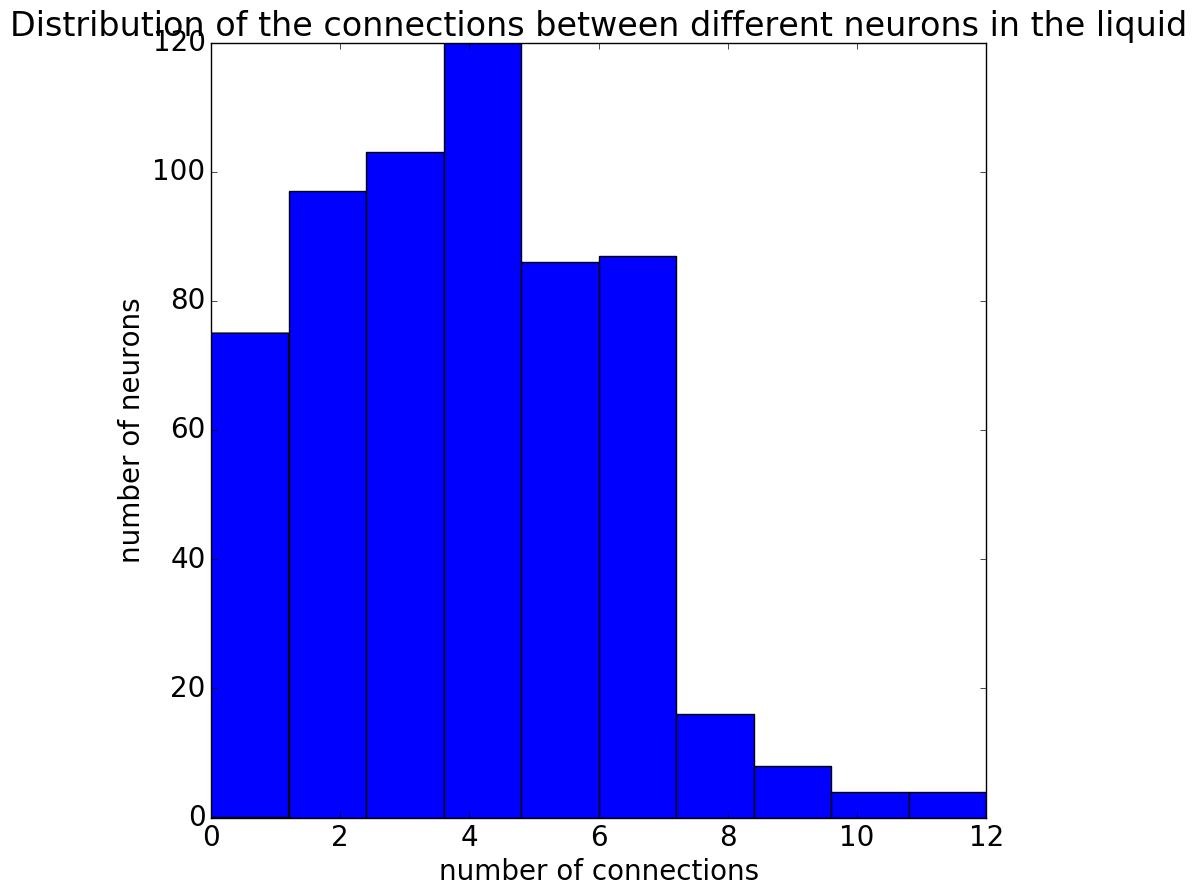

In [9]:
plt.figure(figsize=(10,10))
plt.hist(neurons_connections);
plt.xlabel("number of connections")
plt.ylabel("number of neurons")
plt.title("Distribution of the connections between different neurons in the liquid")
# plt.savefig("liquid_conn_histogram.pdf")
plt.show()

In [10]:
# Now I'm getting the information about the position of the neuron inside the liquid
Neuron3DMatrix=output_L_L['3Dplot_a']

Neuron3DMatrix = numpy.array(Neuron3DMatrix, dtype=numpy.int)

# And creating a matrix with the number of connections to other neurons
XYZ=numpy.zeros((20,5,6),dtype=numpy.int)
for ni,i in zip((Neuron3DMatrix),range(600)):
    XYZ[ni[0]+10,ni[1],ni[2]+3]=neurons_connections[i]

In [11]:
# In order to show in a map, I'm adding according to the plane: Y,Z; X,Z; X,Y 
XYZ.sum(axis=0).shape,XYZ.sum(axis=1).shape,XYZ.sum(axis=2).shape

((5, 6), (20, 6), (20, 5))

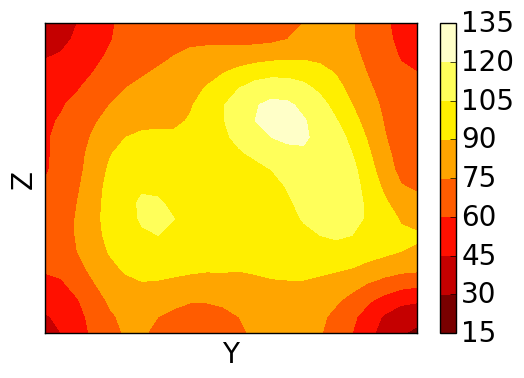

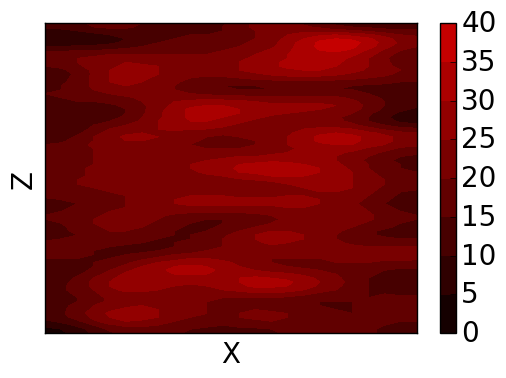

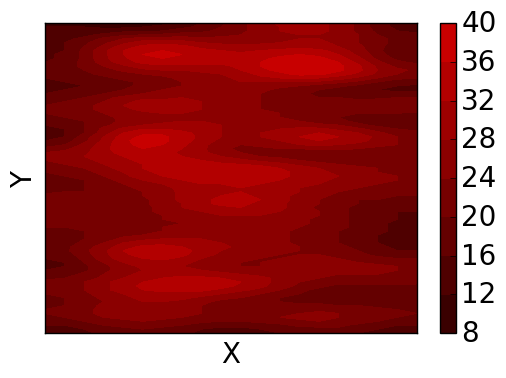

In [12]:
#
# Generates a visualisation of the connection density inside the liquid
# 

import matplotlib.pyplot as plt
from matplotlib  import cm
import scipy.ndimage
from matplotlib import gridspec

alias_set=4

# plt.figure(figsize=(15,10))

# gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1]) 

# plt.subplot(2,2,1)
# plt.subplot(gs[0])
plt.figure()
plt.contourf(scipy.ndimage.zoom(XYZ.sum(axis=0), alias_set),cmap = cm.hot, vmin=0, vmax=135)
plt.xlabel("Y")
plt.ylabel("Z")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

# plt.subplot(2,2,2)
# plt.subplot(gs[1])
plt.figure()
plt.contourf(scipy.ndimage.zoom(XYZ.sum(axis=1), alias_set),cmap = cm.hot, vmin=0, vmax=135)
plt.xlabel("X")
plt.ylabel("Z")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

# plt.subplot(2,2,3)
# plt.subplot(gs[2])
plt.figure()
plt.contourf(scipy.ndimage.zoom(XYZ.sum(axis=2), alias_set),cmap = cm.hot, vmin=0, vmax=135)
plt.xlabel("X")
plt.ylabel("Y")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

# plt.savefig("liquid_conn_contour.pdf")
# plt.show()

In [13]:
# 2DoF example:
Number_of_neurons_lsm = 600
Number_of_input_layers = 6
Number_of_neurons_inputs = 50
input_gain=70


w_SD = 3.0
inputs_indices = []
inputs_weights = []


def gaussian(lamb,n,nt):
    '''
    Generates a gaussian centered at 'n'
    '''
    return input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #No energy normalization

weight_func = gaussian


# Goes through the liquid to generate the proper connections, but dividing the liquid into the same number of input layers
liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))
for inp in range(Number_of_input_layers):
    temp_i=[]
    temp_w=[]
    for i in range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)):
        temp_i2 = []
        temp_w2 = []
        for j,ji in zip(range(inp*liquid_input_layer_size,liquid_input_layer_size*(inp+1)),range(liquid_input_layer_size)):
            if j not in inhibitory_index_L:
                temp_i2.append([i,j])
                centre_position=(i-(inp*Number_of_neurons_inputs))*(liquid_input_layer_size-1)/float(Number_of_neurons_inputs)
                temp_w2.append(weight_func(w_SD,centre_position,ji)) # in nA
        temp_i.append(temp_i2)
        temp_w.append(temp_w2)
    inputs_indices.append(temp_i)
    inputs_weights.append(temp_w)

In [14]:
liquid_input_layer_size # these are the liquid unique slice size each input variable injects its inputs

100

In [15]:
len(inputs_indices),len(inputs_indices[0]),len(inputs_indices[0][0]) 
#(number of input variables, size of the input layer, total available liquid excitatory neurons)

(6, 50, 84)

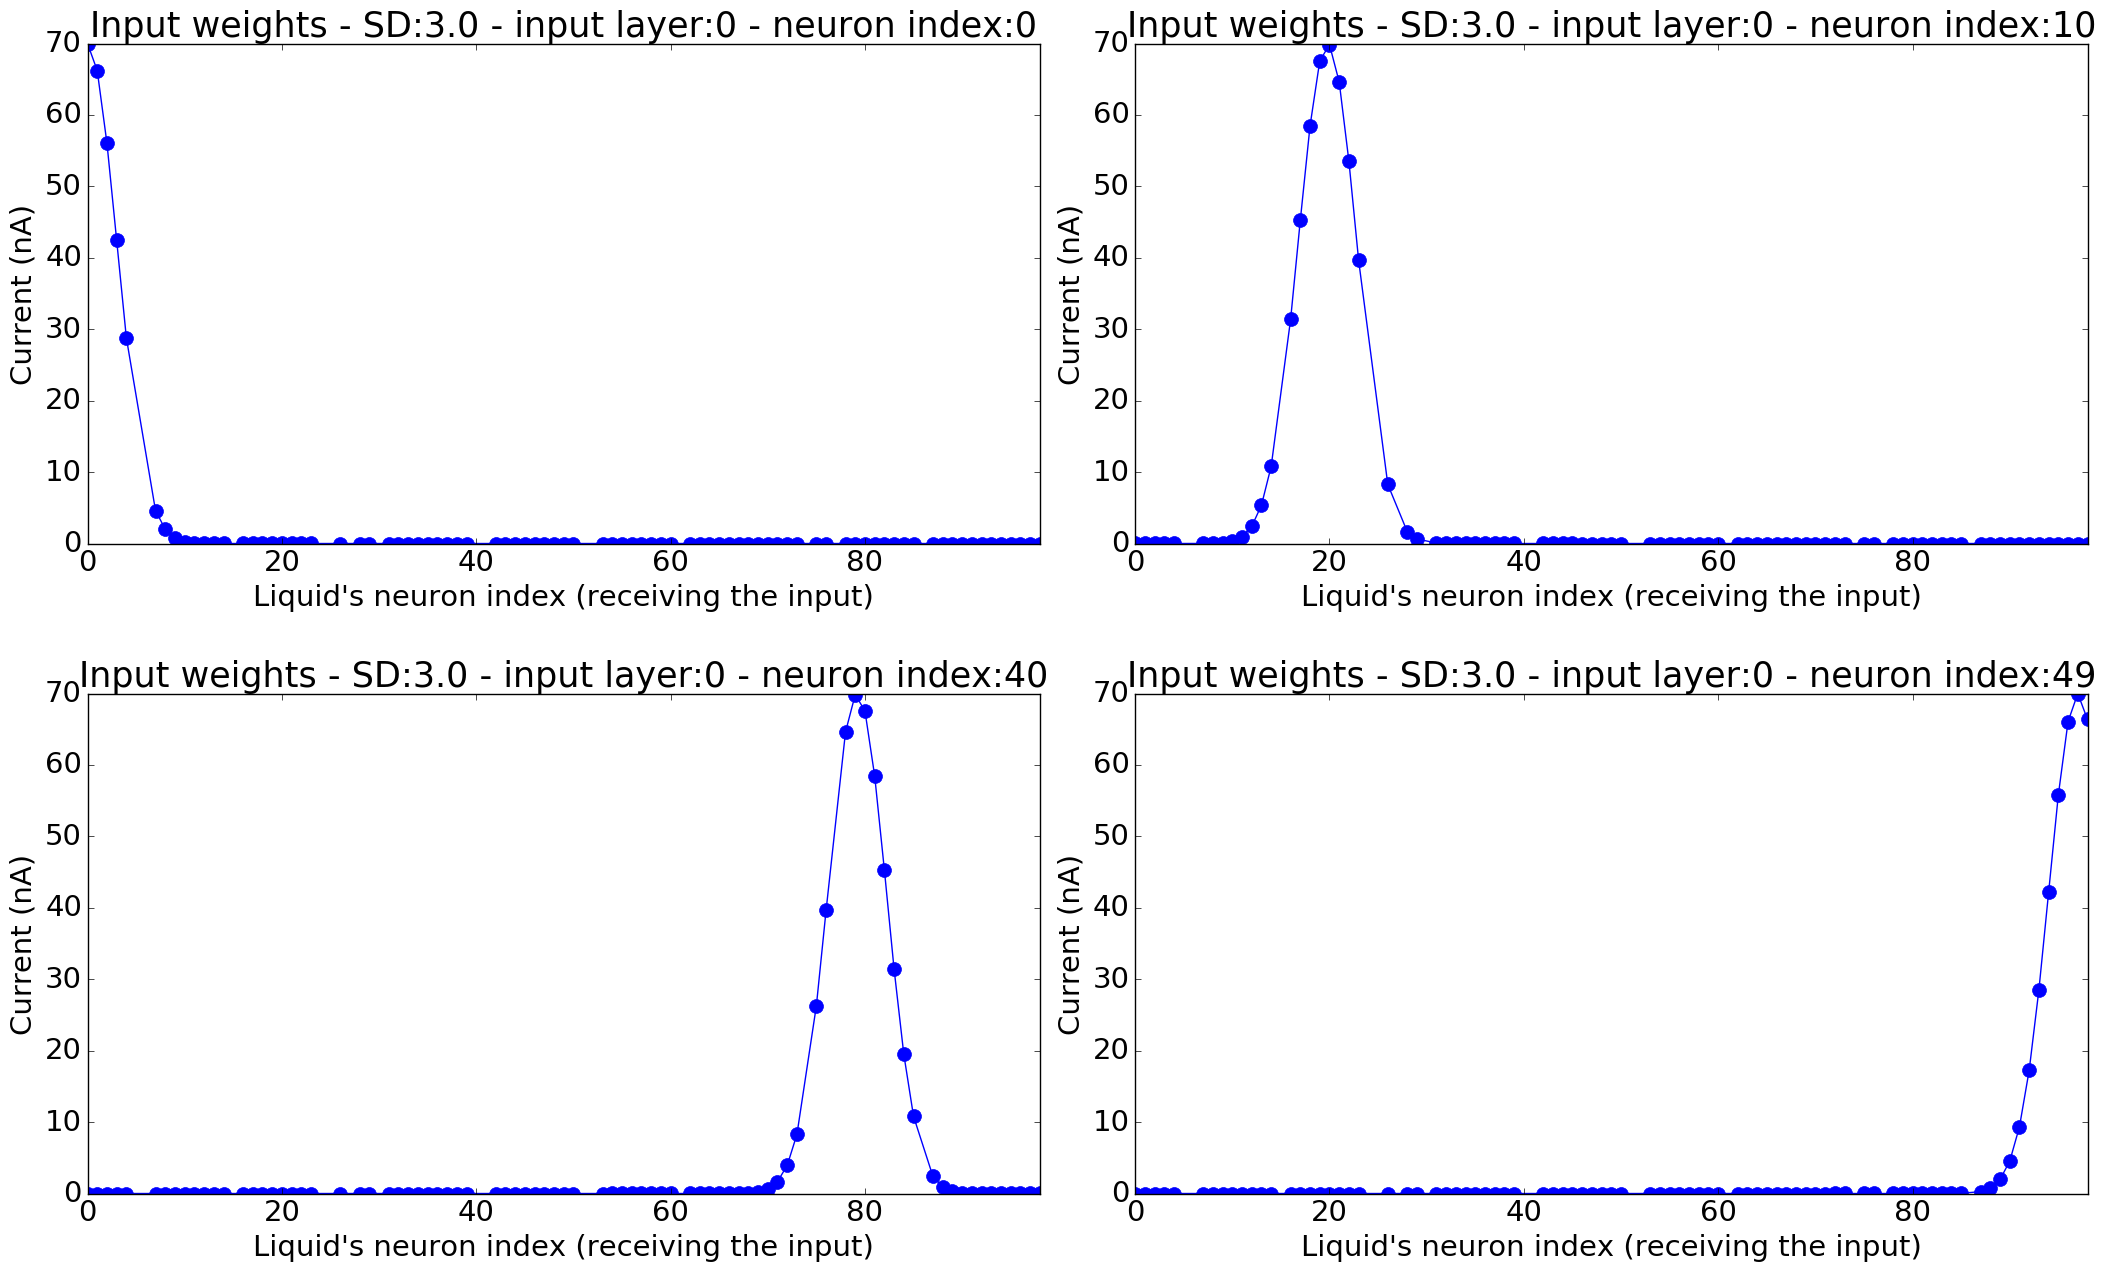

In [16]:
font = {'weight' : 'normal',
        'size'   : 21}

matplotlib.rc('font', **font)

base_dir = "2DofArm_simulation_data"

input_variable=0
neuron_indexs=[0,10,40,Number_of_neurons_inputs-1]
plt.figure(figsize=(20,20))

for ni,i in zip(neuron_indexs,range(1,7)):
    plt.subplot(3,2,i)
    plt.plot(numpy.array(inputs_indices[input_variable][ni])[:,1],inputs_weights[input_variable][ni],'.-',markersize=20)
    plt.title("Input weights - SD:"+str(w_SD)+" - input layer:"+str(input_variable)+" - neuron index:"+str(ni))
    plt.xlabel("Liquid's neuron index (receiving the input)")
    plt.ylabel("Current (nA)")
    plt.xlim(numpy.array(inputs_indices[input_variable][ni])[:,1].min(),numpy.array(inputs_indices[input_variable][ni])[:,1].max())

plt.subplots_adjust(left=0, bottom=.1, right=1, top=1,wspace=.1, hspace=.3)
plt.savefig("./"+base_dir+"/example_weights_exp1.pdf", bbox_inches='tight',pad_inches=1)    
plt.show()

In [17]:
font = {'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

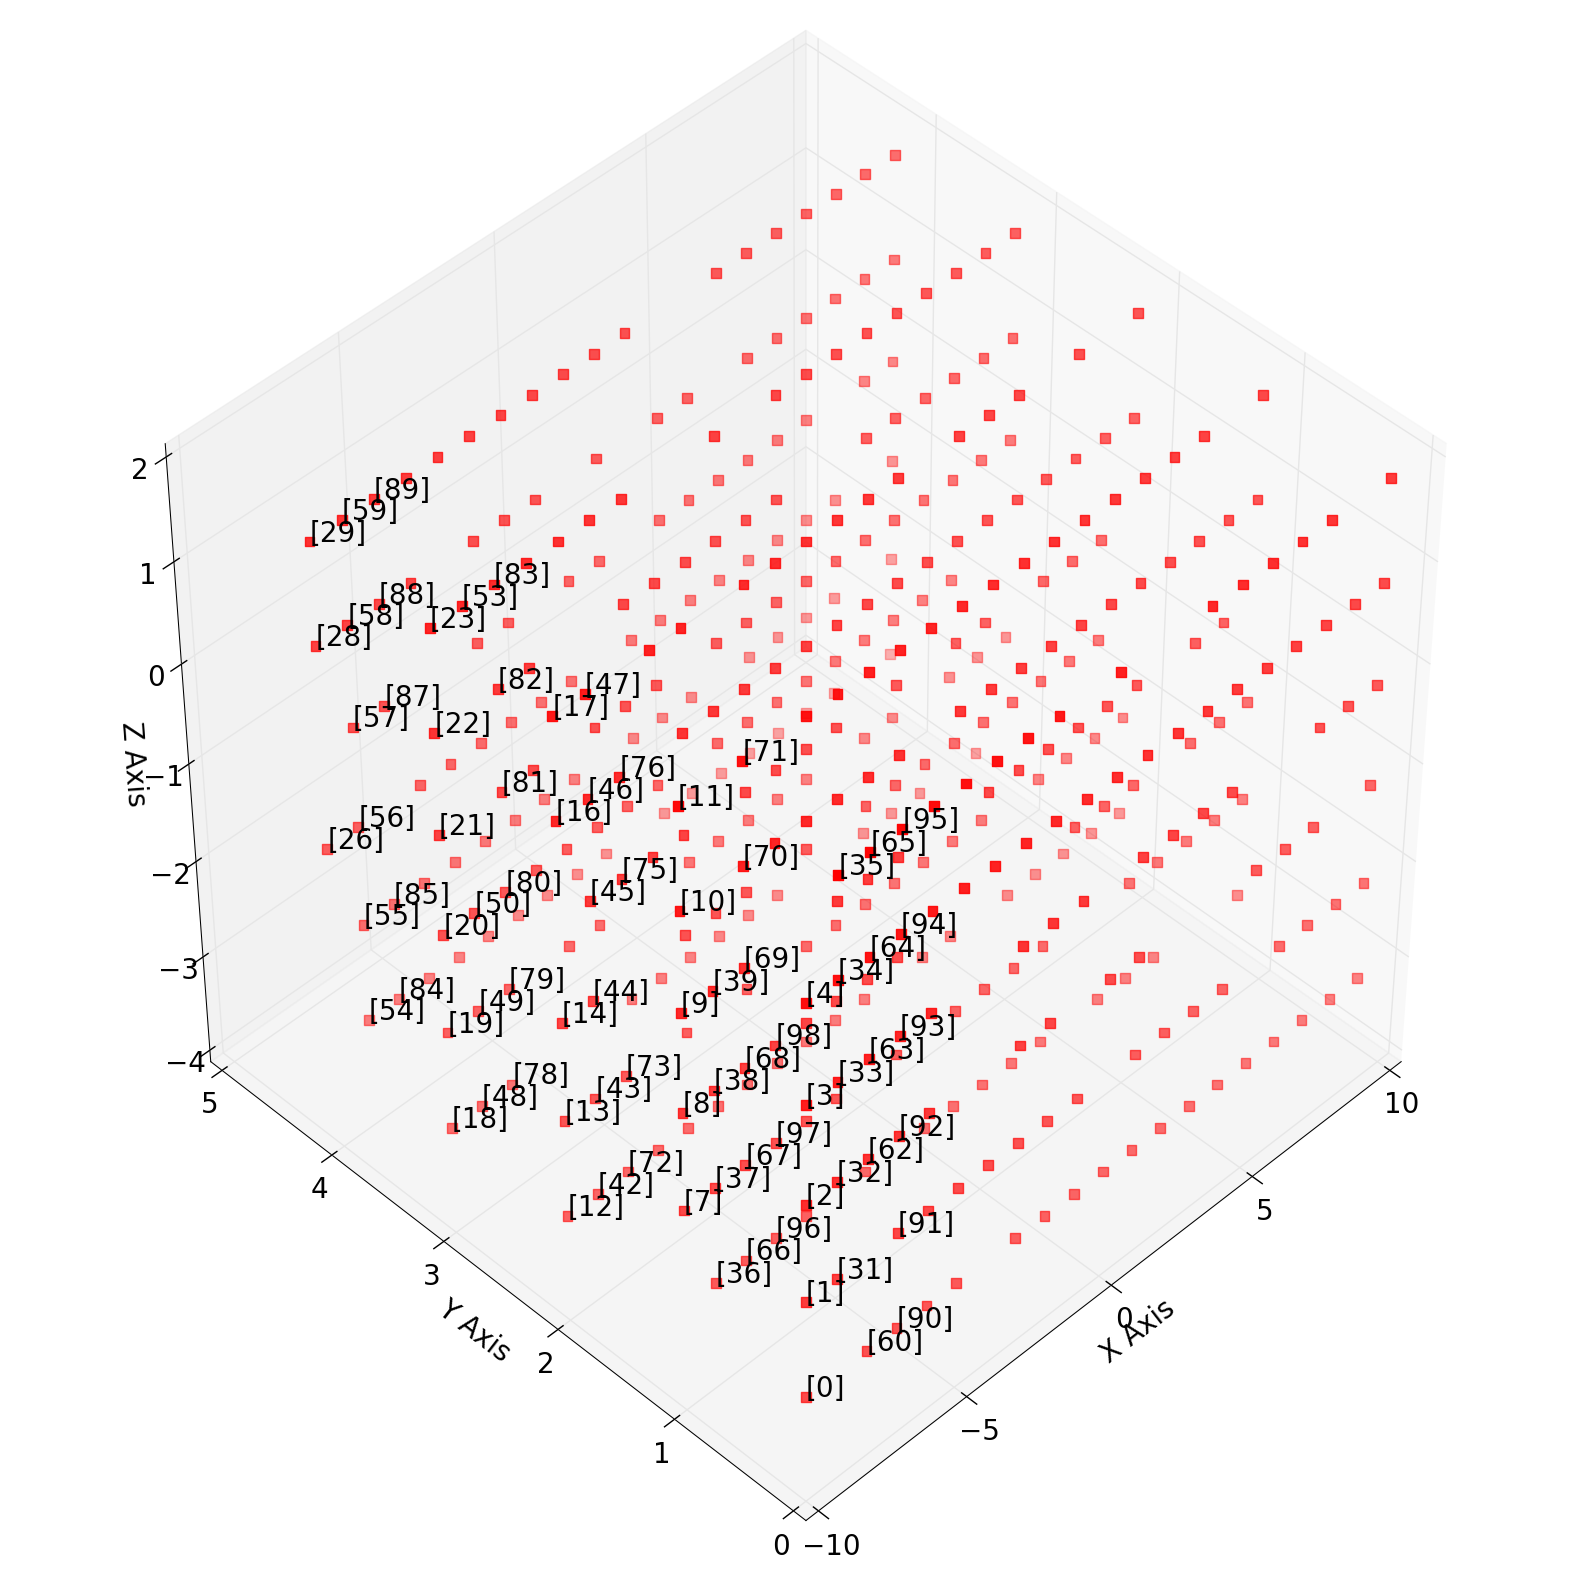

In [62]:
# 
# Remember to execute the cell (way below this one) where the show_3d_connections is defined :D
# 

input_variable=0 # The index goes from 0 to 5 => [x,y,teta1,teta2,tau1,tau2]
neuron_index=0 # Doesn't matter because only weights change...

# Draws the Liquid 3D grid with the connections
show_3d_connections(output_L_L, inhibitory_index_L, \
                    imgtitle='',\
                    filename="input_liquid_slice.pdf",                    
                    show_index=True, show_inh=False, show_conn=False, \
                    tag_indices=numpy.array(inputs_indices[input_variable][neuron_index])[:,1],
                    imgsize=(20,20))

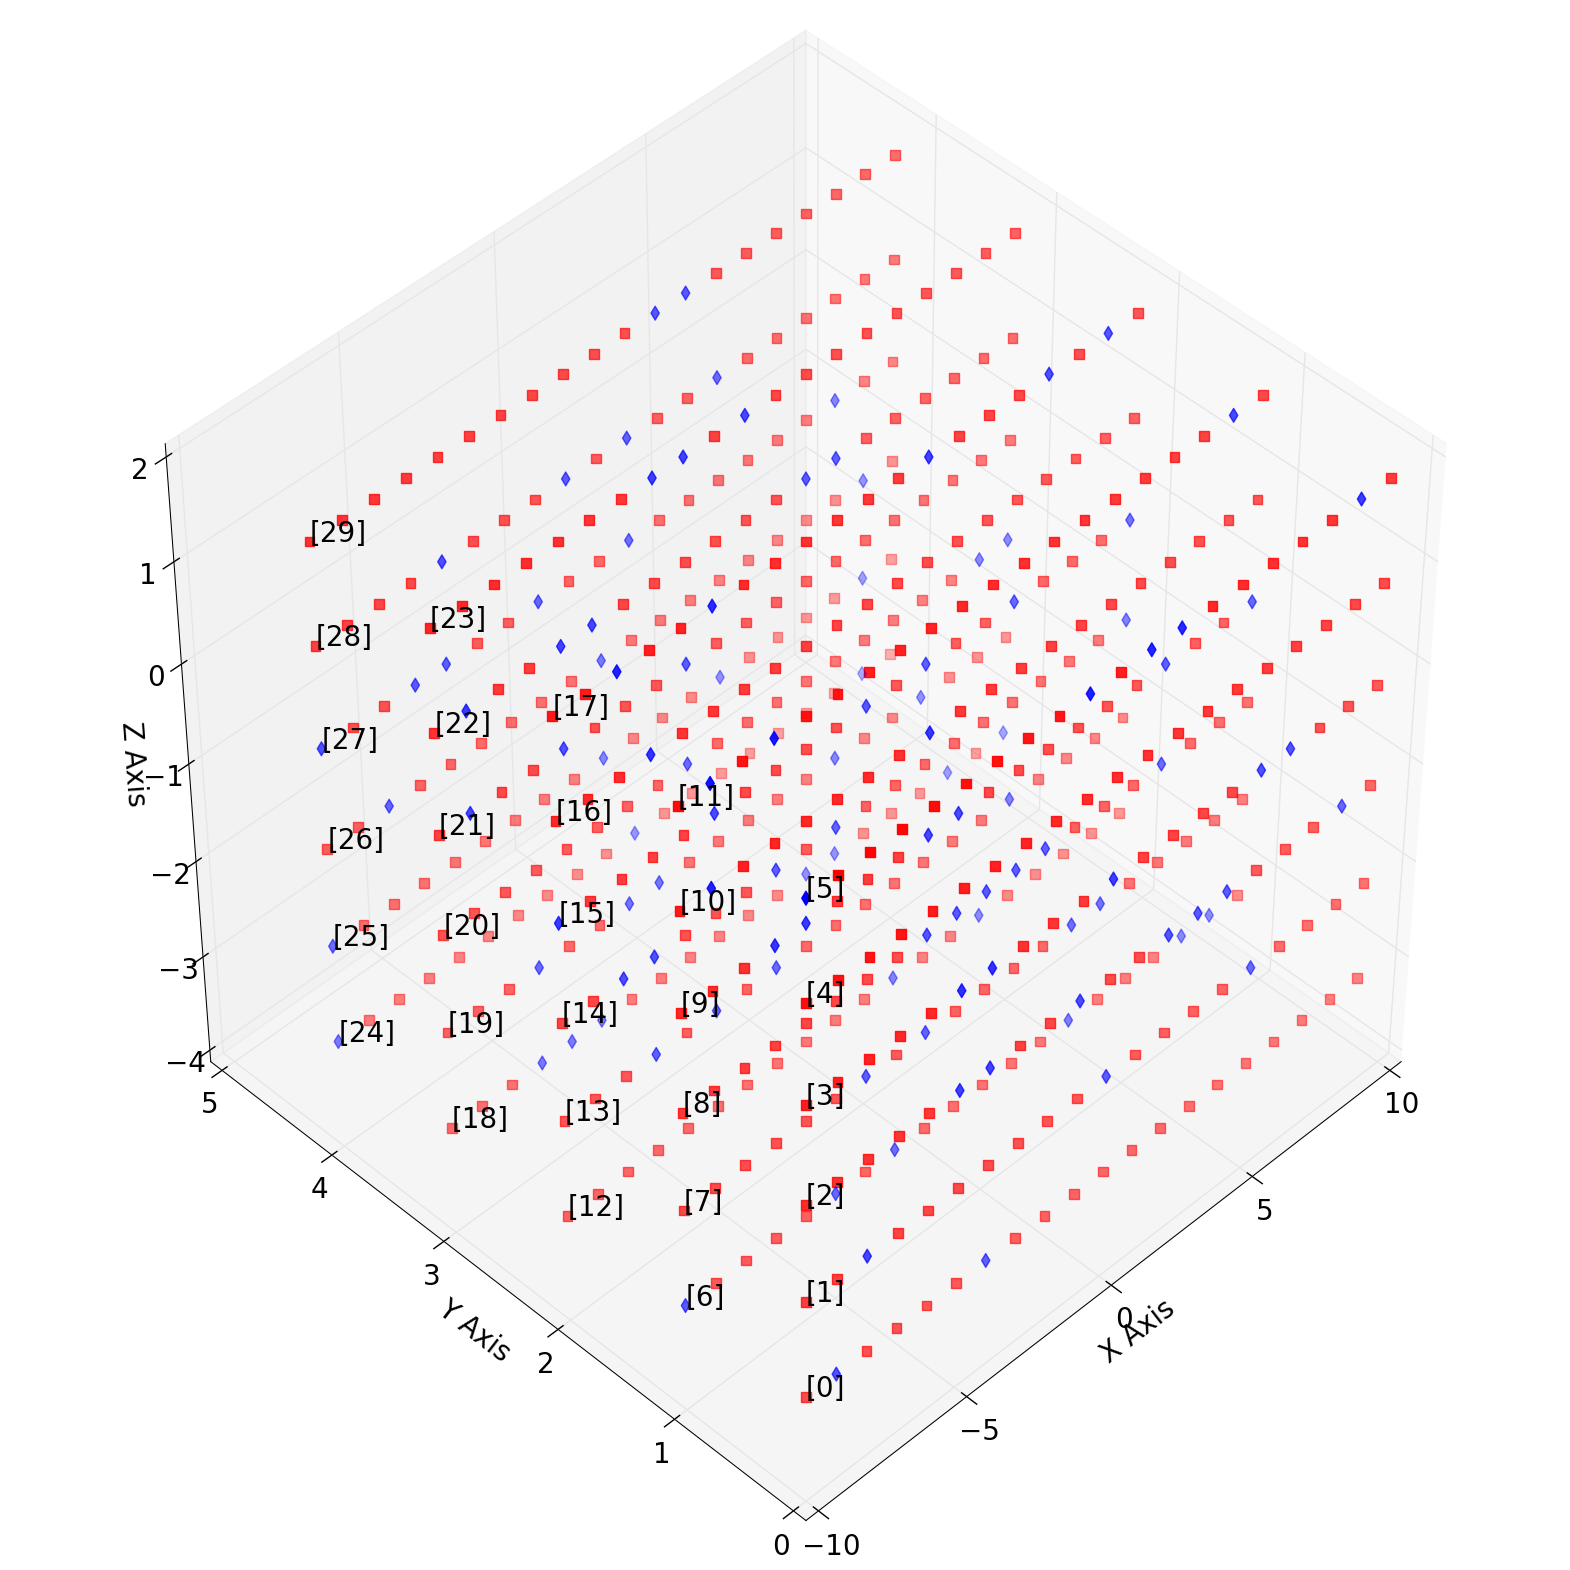

In [63]:
# Draws the Liquid 3D grid with the connections
show_3d_connections(output_L_L, inhibitory_index_L, \
                    imgtitle='',\
                    filename="liquid_index_example.pdf",                    
                    show_index=True, show_inh=True, show_conn=False, \
                    tag_indices=numpy.array(range(30)))

In [32]:
example=numpy.arange(600).reshape((20,5,6))
example[0]

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29]])

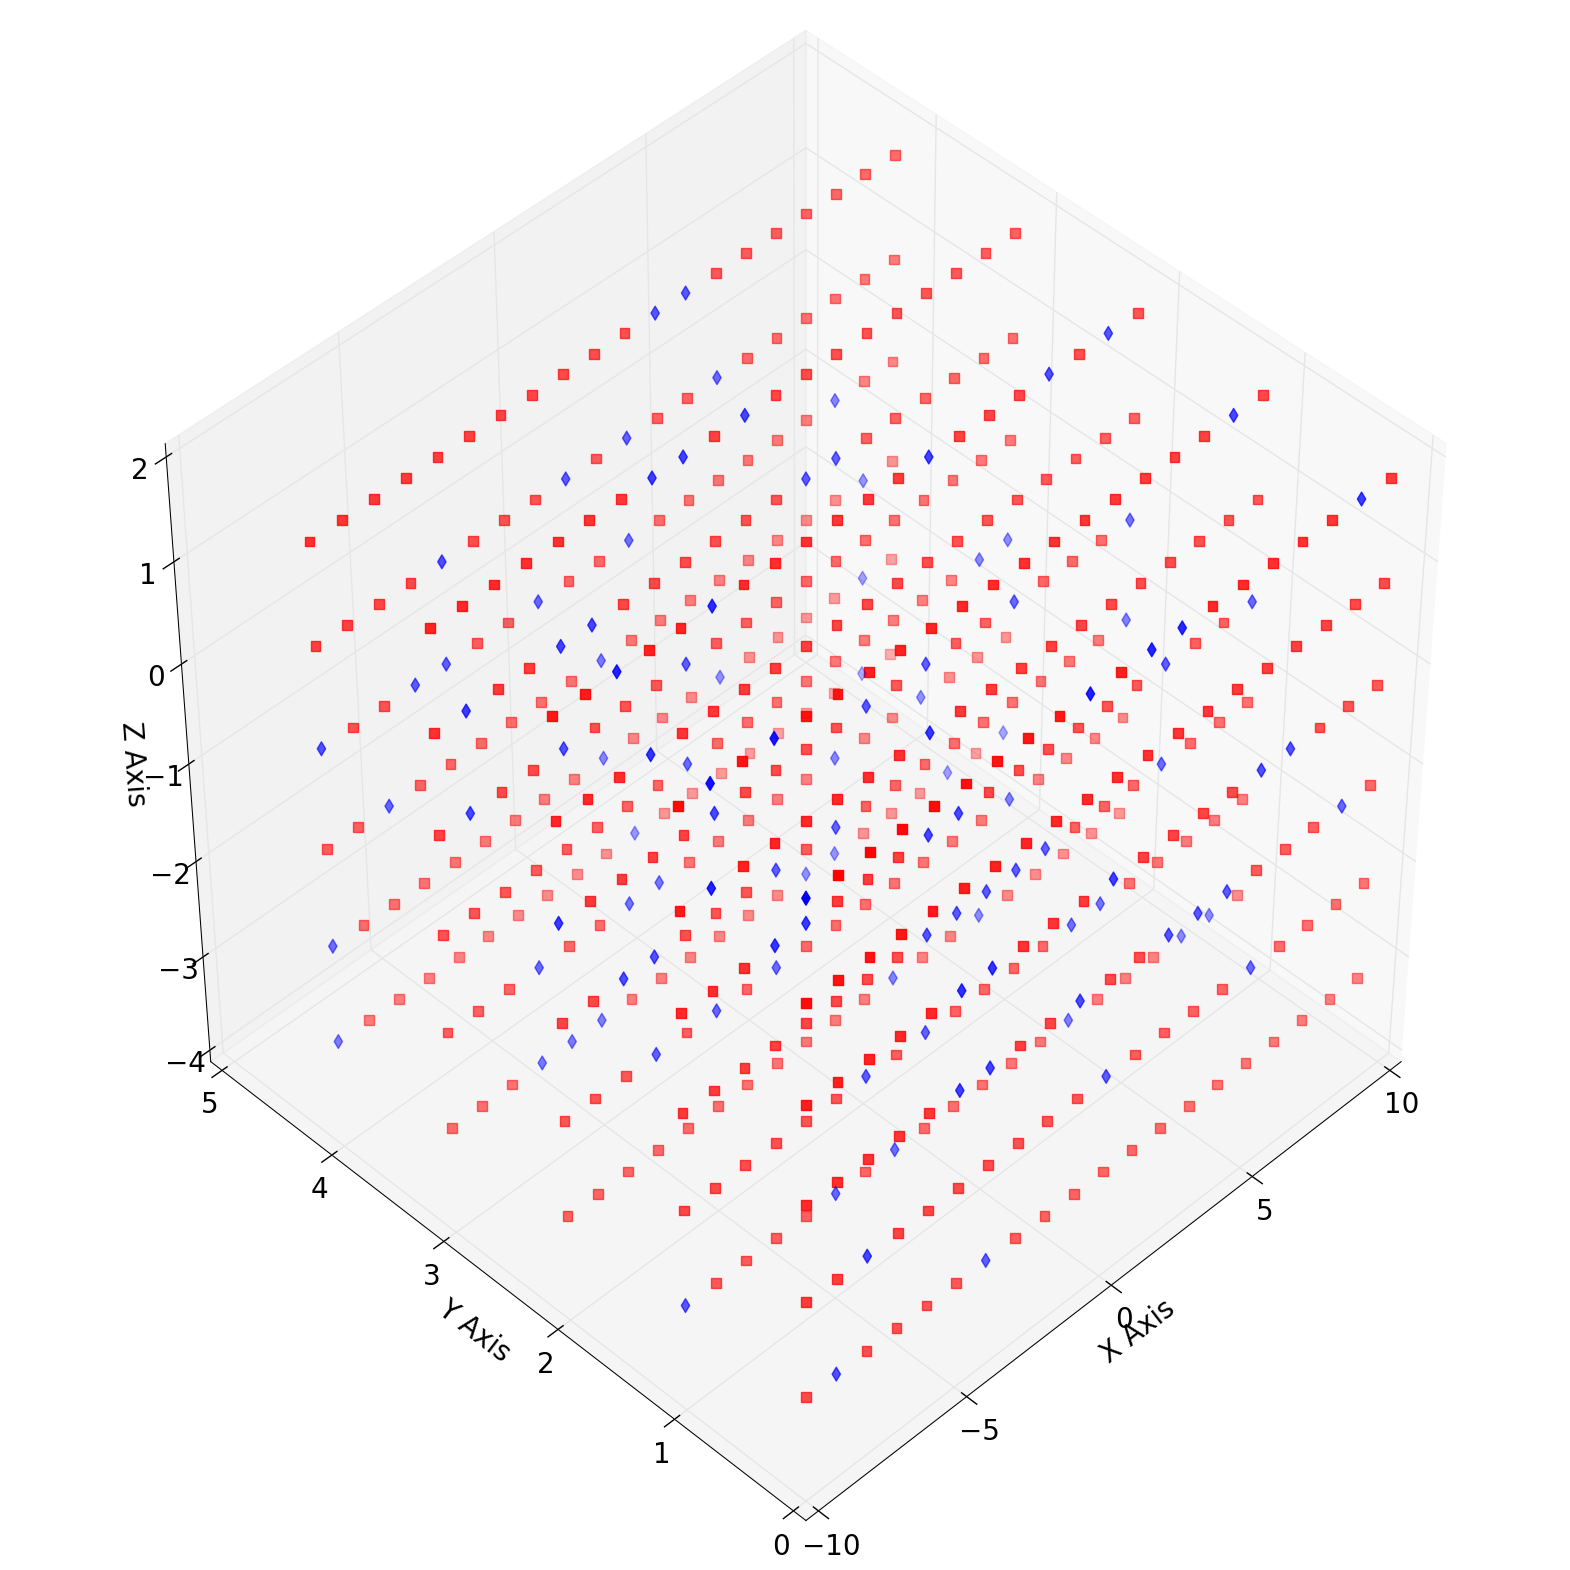

In [61]:
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# Draws the Liquid 3D grid with the connections
show_3d_connections(output_L_L, inhibitory_index_L, \
                    imgtitle='',\
                    filename="disconnected_liquid.pdf",
                    show_index=False, show_conn=False, tag_indices=range(0,60)+range(540,600))


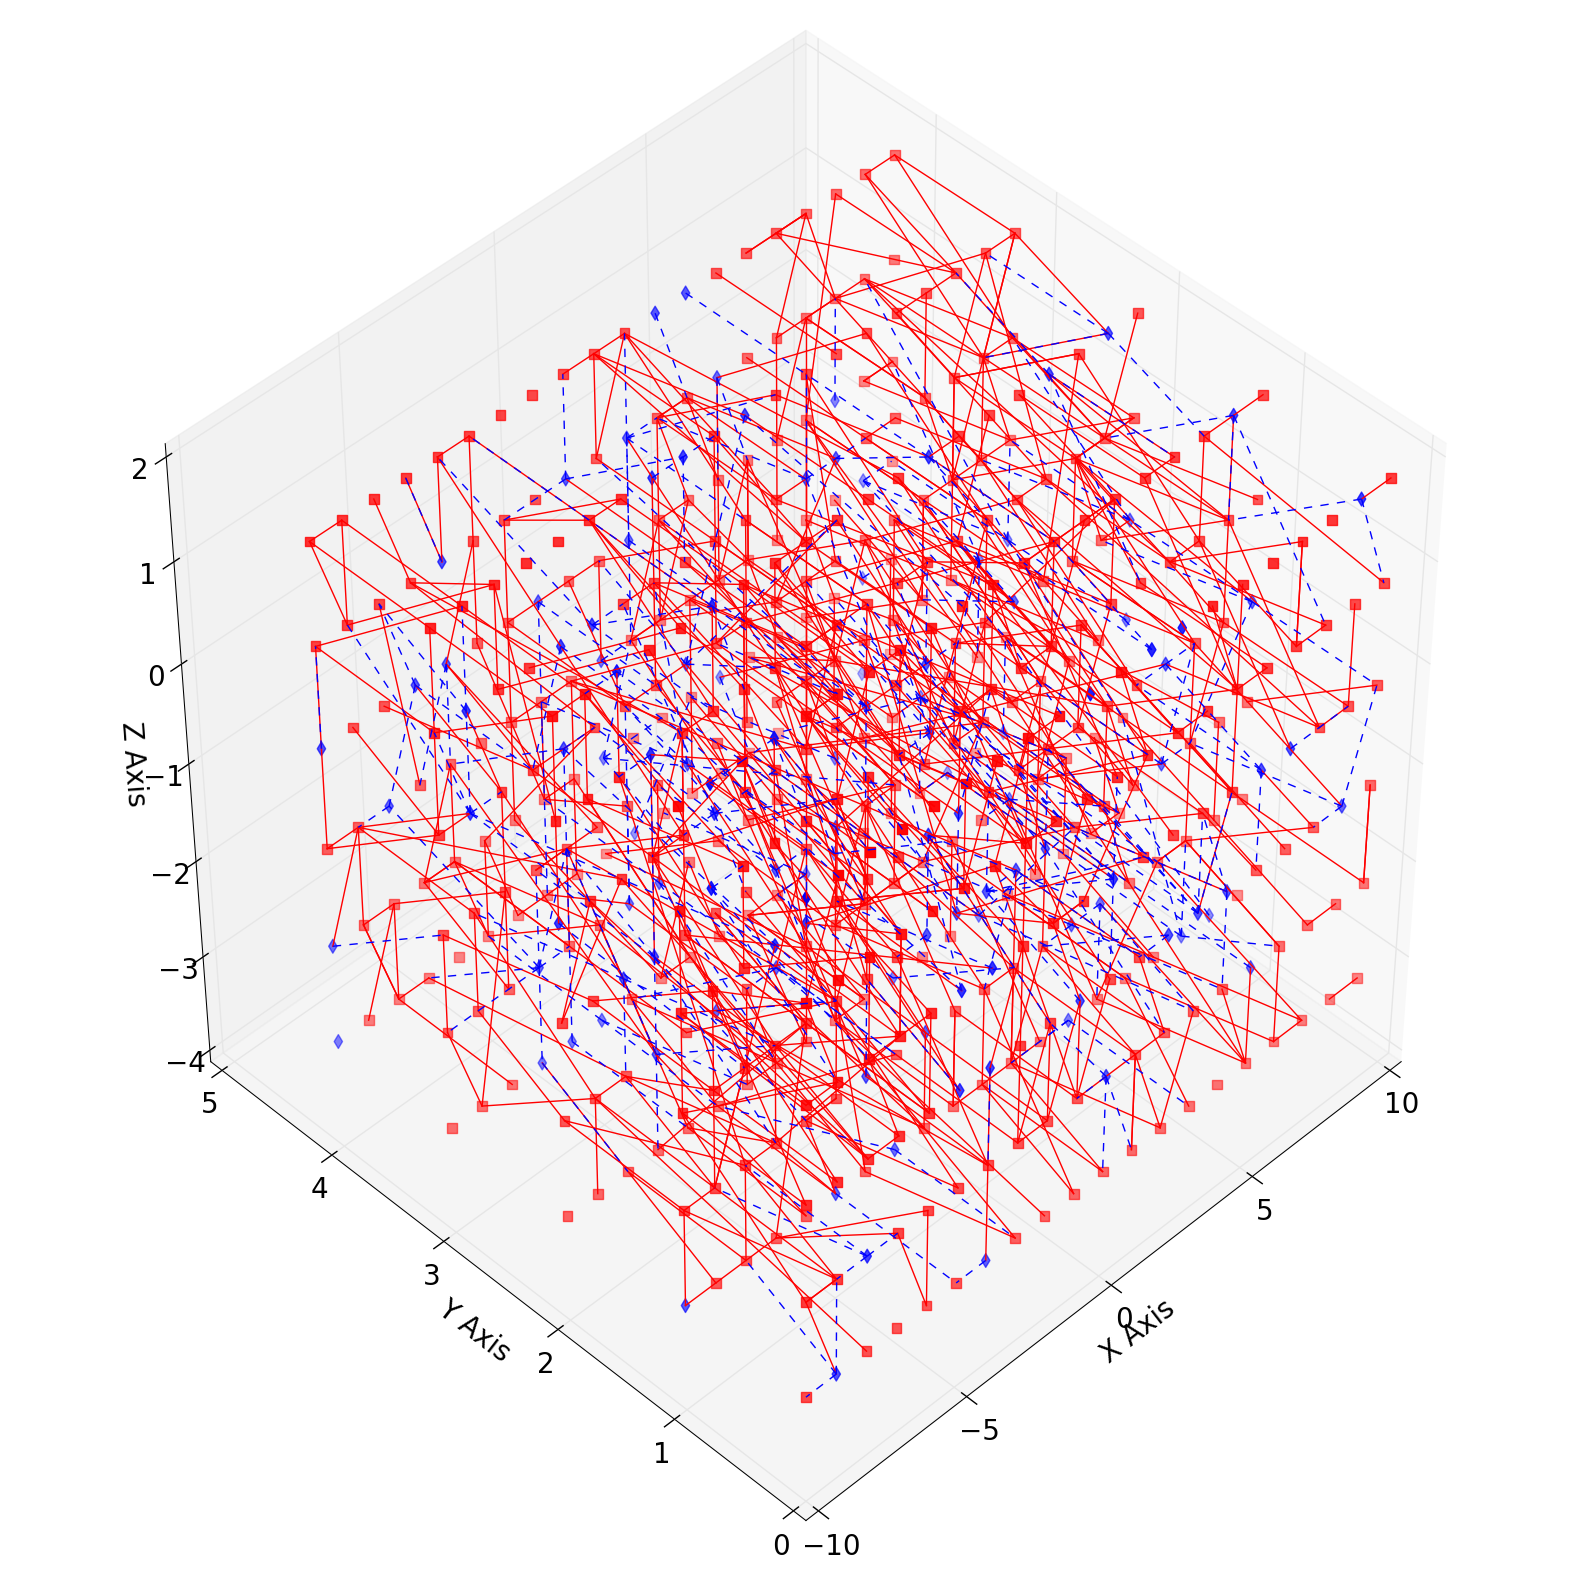

In [60]:
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# Draws the Liquid 3D grid with the connections
show_3d_connections(output_L_L, inhibitory_index_L, \
                    imgtitle='',\
                    filename="connected_liquid.pdf",
                    show_index=False, show_conn=True, tag_indices=range(0,60)+range(540,600))

In [59]:
# Generate the points to the 3D Scatter plot

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def show_3d_connections(output, inh_indices, show_exc=True, show_inh=True, \
                        show_conn=True, show_arrows=False, show_index=False, \
                        show_coord=False, return_figure=False, imgsize=(20,20), \
                        imgtitle='Liquid 3D Structure', camera=(45,-135), tag_indices=range(600),\
                        filename="", xlim=[-10,10], ylim=[0,5], zlim=[-4,2]):
        '''
        Prints the neurons and the connections between them using the output from lsm_connections_probability module.
        output->is the output from the generate_liquid_connections function (from lsm_connections_probability.py)
        show_number=True->shows the index number of each neuron according to the Neurongroup
        '''
        
        user_elev,user_azim = camera
        size_x=imgsize[0]
        size_y=imgsize[1]
        
        if output['3Dplot_a']==output['3Dplot_b']: # It means population 'a' and 'b' are the same!
            Neuron3DMatrix=output['3Dplot_a']
        else:
            Neuron3DMatrix=output['3Dplot_a']+output['3Dplot_b'] # This works here because they are two LISTS and "NOT" NUMPY ARRAYS.

        Neuron3DMatrix = numpy.array(Neuron3DMatrix)


        # List of tuples with (pre synaptic, post synaptic) EXCITATORY->ANYTHING neurons connections indexes
        exc_connect_positions=[output['exc'][i][0] for i in range(len(output['exc']))]
        exc_connect_positions_pre=[output['3Dplot_a'][i[0]] for i in exc_connect_positions]
        exc_connect_positions_post=[output['3Dplot_b'][i[1]] for i in exc_connect_positions]

        # List of tuples with (pre synaptic, post synaptic) INHIBITORY->ANYTHING neurons connections indexes
        inh_connect_positions=[output['inh'][i][0] for i in range(len(output['inh']))]
        inh_connect_positions_pre=[output['3Dplot_a'][i[0]] for i in inh_connect_positions]
        inh_connect_positions_post=[output['3Dplot_b'][i[1]] for i in inh_connect_positions]

        fig = plt.figure(figsize =(size_x,size_y)) # creates the figure for the following plots
        ax = fig.add_subplot(111, projection='3d') # setup to only one

        exc_indices = [i for i in range(len(Neuron3DMatrix)) if i not in inh_indices]
        
        Neuron3DMatrix_inh=Neuron3DMatrix[inh_indices]
        Neuron3DMatrix_exc=Neuron3DMatrix[exc_indices]        
        
        if show_exc:
            ax.scatter(Neuron3DMatrix_exc[:,0],Neuron3DMatrix_exc[:,1],Neuron3DMatrix_exc[:,2], color = 'red', s=50, marker="s")

        if show_inh:
            ax.scatter(Neuron3DMatrix_inh[:,0],Neuron3DMatrix_inh[:,1],Neuron3DMatrix_inh[:,2], color = 'blue', s=50, marker="d")
        
#         ax.scatter(x, y, z) # plots the points correnponding to the neurons

        # Insert a label with the position of each neuron according to the positions_list (NeuronGroup)
        if show_index:
            for ti in tag_indices:
                t=Neuron3DMatrix[ti]
                ax.text(t[0], t[1], t[2], "["+str(ti)+"]")

        # Insert a label with the 3D coordinate used to calculate the connection probabilities
        if show_coord:
            for ti in tag_indices:
                t=Neuron3DMatrix[ti]
                ax.text(t[0], t[1], t[2], str(t)+"="+str(ti)) # to insert also the coordinates of the point

        #
        # Draw a 3D vector (arrow)
        from matplotlib.patches import FancyArrowPatch
        from mpl_toolkits.mplot3d import proj3d

        class Arrow3D(FancyArrowPatch):
            def __init__(self, xs, ys, zs, *args, **kwargs):
                FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
                self._verts3d = xs, ys, zs

            def draw(self, renderer):
                xs3d, ys3d, zs3d = self._verts3d
                xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
                self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
                FancyArrowPatch.draw(self, renderer)

        if show_conn:
            if show_arrows:
                if show_exc:
                    # Plot the EXCITATORY connections
                    for i in range(len(exc_connect_positions)):
                        a = Arrow3D(
                            [ exc_connect_positions_pre[i][0], exc_connect_positions_post[i][0] ], 
                            [ exc_connect_positions_pre[i][1], exc_connect_positions_post[i][1] ], 
                            [ exc_connect_positions_pre[i][2], exc_connect_positions_post[i][2] ], 
                            label='excitatory connections', mutation_scale=20, lw=1, arrowstyle="-|>", color="r")
                        ax.add_artist(a)

                if show_inh:
                    # Plot the INHIBITORY connections
                    for i in range(len(inh_connect_positions)):
                        a = Arrow3D(
                            [ inh_connect_positions_pre[i][0], inh_connect_positions_post[i][0] ], 
                            [ inh_connect_positions_pre[i][1], inh_connect_positions_post[i][1] ], 
                            [ inh_connect_positions_pre[i][2], inh_connect_positions_post[i][2] ], 
                            label='inhibitory connections', mutation_scale=20, lw=1, arrowstyle="-|>", color="b")
                        ax.add_artist(a)                    
            else:

                if show_exc:
                    # Plot the EXCITATORY connections - FAST VERSION WITHOUT ARROWS
                    for i in range(len(exc_connect_positions)):
                        ax.plot(
                            [ exc_connect_positions_pre[i][0], exc_connect_positions_post[i][0] ], 
                            [ exc_connect_positions_pre[i][1], exc_connect_positions_post[i][1] ], 
                            [ exc_connect_positions_pre[i][2], exc_connect_positions_post[i][2] ], 
                            label='excitatory connections', color='#FF0000', linestyle='-')


                if show_inh:
                    # Plot the INHIBITORY connections - FAST VERSION WITHOUT ARROWS
                    for i in range(len(inh_connect_positions)):
                        ax.plot(
                            [ inh_connect_positions_pre[i][0], inh_connect_positions_post[i][0] ], 
                            [ inh_connect_positions_pre[i][1], inh_connect_positions_post[i][1] ], 
                            [ inh_connect_positions_pre[i][2], inh_connect_positions_post[i][2] ], 
                            label='inhibitory connections', color='#0000FF', linestyle='--')

        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        
        plt.title(imgtitle)
        
        ax.view_init(elev=user_elev, azim=user_azim)
        
        ax.set_xlim3d(xlim[0],xlim[1])
        ax.set_xlim(xlim[0],xlim[1])

        ax.set_ylim3d(ylim[0],ylim[1])
        ax.set_ylim(ylim[0],ylim[1])

        ax.set_zlim3d(zlim[0],zlim[1])
        ax.set_zlim(zlim[0],zlim[1])

        if return_figure:
            return plt,fig,ax
        else:
            if filename!="":
                plt.savefig(filename, bbox_inches='tight',pad_inches=1)    
            plt.show()


In [3]:
# Generates the liquid structure

import numpy
import sys

import save_load_file as slf

import lsm_connections_probability # Creates the 3D Grid and the connections according to Maass 2002
reload(sys.modules['lsm_connections_probability']) # Makes sure the interpreter is going to reload the module
lm = lsm_connections_probability


my_seed=93200
Number_of_neurons_lsm=600
Net_shape = (20,5,6)
lbd_value=1.2

AII=47.0
AIE=47.0
AEI=150.0
AEE=70.0


liq_rs = numpy.random.RandomState(my_seed) # this is the random state used within the liquid structure generation

print "#"*78
print "#"*78
print "Liquid State Machine - 2 DoF arm experiments!"
print "#"*78
print "#"*78



lsm_3dGrid_flat = numpy.zeros(Number_of_neurons_lsm) 
# This creates a numpy 1D array with 'Number_of_neurons_lsm' positions
# I'm using a numpy array to be able to use the reshape method to 
# change from 1D (vector) to 3D (matrix)


def randon_connections_gen(Number_of_neurons, ratio, number=None):
    '''
    Generate the random neuron indexes list according to the number of neurons and the ratio
    '''
    # List used to generate the randoms 'ratio' indexes for the Liquid
    l_range = range(Number_of_neurons)

    # Generates the random "indexes" of the flattened version of the 3DGrid.
    # At each iteration one random item is extracted from l_range and inserted in connection_index.
    # This is the way I've found to sample without repetitions.
    # - Another way is using the shuffle from numpy and then grabbing the first N values!      
    if number==None:
        connection_index = [l_range.pop(liq_rs.randint(0,len(l_range))) for i in range(int(Number_of_neurons*ratio))] 
    else:
        connection_index = [l_range.pop(liq_rs.randint(0,len(l_range))) for i in range(int(number))] 
    connection_index.sort() #This is only useful to make easier to human beings to read the list :)

    return connection_index


#
# Number of Inhibitory and Excitatory neurons - LIQUID - 20% of the total neurons
inhibitory_index_L = randon_connections_gen(Number_of_neurons_lsm, 0.2)


# This is the dictionary that has all the connections parameters according to Maass 2002.
# It is necessary to create the 3D connections and the STP configuration matrices
# E=>1 (excitatory) and I=>0 (inhibitory)
# Ex.: (0,0) => II
# Dynamical Synapses Parameters (STP):
Connections_Parameters={
              (0,0):[ # II
                      0.1,       # CGupta=0.1        # Parameter used at the connection probability - from Maass2002 paper
                      0.32,      # UMarkram=0.32     # Use (U) - Parameter used at the Dynamic Synapse - from Maass2002 paper
                      0.144,     # DMarkram=0.144    # Time constant for Depression (tau_rec) - used at the Dynamic Synapse - from Maass2002 paper                    
                      0.06,      # FMarkram=0.06     # Time constant for Facilitation (tau_facil) - used at the Dynamic Synapse - from Maass2002 paper
                      AII,       # AMaass=2.8        # (nA) In the Maass2002 paper the value is negative, but because I need a positive scale (random.normal parameter) and there is a negative sign in front of the abs function I changed this to positive
                      0.8        # Delay_trans = 0.8 # In Maass paper the transmission delay is 0.8 to II, IE and EI        
                  ],
              (0,1):[ # IE
                      0.4,    # CGupta=0.4
                      0.25,   # UMarkram=0.25
                      0.7,    # DMarkram=0.7
                      0.02,   # FMarkram=0.02
                      AIE,    # AMaass=3.0 #in the Maass2002 paper the value is negative, but because I need a positive scale (random.normal parameter) and there is a negative sign in front of the abs function I changed this to positive
                      0.8     # Delay_trans = 0.8 # in Maass paper the transmission delay is 0.8 to II, IE and EI
                  ],
              (1,0):[ # EI
                      0.2,    # CGupta=0.2
                      0.05,   # UMarkram=0.05
                      0.125,  # DMarkram=0.125
                      1.2,    # FMarkram=1.2
                      AEI,    # AMaass=1.6
                      0.8     # Delay_trans = 0.8 # in Maass paper the transmission delay is 0.8 to II, IE and EI
                  ],
              (1,1):[ # EE
                      0.3,    # CGupta=0.3 
                      0.5,    # UMarkram=0.5
                      1.1,    # DMarkram=1.1
                      0.05,   # FMarkram=0.05
                      AEE,    # AMaass=1.2 #scaling parameter or absolute synaptic efficacy or weight - from Maass2002 paper
                      1.5     # Delay_trans = 1.5 # in Maass paper the transmission delay is 1.5 to EE connection
                  ]
              }


# Utilizes the functions in the lsm_connections_probability.py
# =>output = {'exc':connections_list_exc,'inh':connections_list_inh, '3Dplot_a':positions_list_a, '3Dplot_b':positions_list_b}
# connections_list_exc= OR connections_list_inh=
    # ((i,j), # PRE and POS synaptic neuron indexes
    # pconnection, # probability of the connection
    # (W_n, U_ds, D_ds, F_ds), # parameters according to Maass2002
    # Delay_trans, # parameters according to Maass2002
    # connection_type)

# Generate the connections matrix inside the Liquid (Liquid->Liquid) - according to Maass2002
#
print "Liquid->Liquid connections..."

print "Generating the Liquid->Liquid connections..."
output_L_L = lm.generate_connections(lsm_3dGrid_flat, inhibitory_index_L, Net_shape, 
                                  CParameters=Connections_Parameters, lbd=lbd_value, randomstate=liq_rs) 
                                # lbd controls the connections
                                # randomstate receives a numpy.random.RandomState object, or automatically sets a random one.



print "Liquid->Liquid connections...Done!"

slf.save_to_file(output_L_L,'output_L_L_RDC2.pickle')
slf.save_to_file(inhibitory_index_L,'inhibitory_index_L_RDC2.pickle')

##############################################################################
##############################################################################
Liquid State Machine - 2 DoF arm experiments!
##############################################################################
##############################################################################
Liquid->Liquid connections...
Generating the Liquid->Liquid connections...
Liquid->Liquid connections...Done!
